In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import math
import collections

In [4]:
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

def reduce_to_first_significant_digit(quantity, uncertainty):
    first_significant_digit = math.floor(math.log10(abs(uncertainty)))
    quantity = round(quantity, -first_significant_digit)
    uncertainty = round(uncertainty, -first_significant_digit)
    return quantity, uncertainty

def plot_correlation_with_SEM(x_lab, y_lab, data, x_err, y_err, title=None, color=None, ax=None):
    # Extract only pKa values.
    x_error = data.loc[:, x_err]
    y_error = data.loc[:, y_err]
    x_values = data.loc[:, x_lab]
    y_values = data.loc[:, y_lab]
    data = data[[x_lab, y_lab]]

    # Find extreme values to make axes equal.
    #min_limit = np.ceil(min(data.min()) -2)
    #max_limit = np.floor(max(data.max()) +2)
    min_limit = 2
    max_limit = 12
    axes_limits = np.array([min_limit, max_limit])
    print("axes limits: ", axes_limits)
    
    # Color
    current_palette = sns.color_palette()
    sns_blue = current_palette[0]
    
    # Plot
    plt.figure(figsize=(6,6))
    grid = sns.regplot(x=x_values, y=y_values, data=data, color=color, ci=None)#scatter_kws={'s':10}
    plt.errorbar(x=x_values, y=y_values, xerr=x_error, yerr=y_error,fmt = "o", ecolor=sns_blue, capthick='2', label='SEM', alpha=0.75, markersize='5')
    #plt.title(title)
    plt.axis("equal")
    
    # Add diagonal line.
    grid.plot(axes_limits, axes_limits, ls='--', c='black', alpha=0.8, lw=0.7)

    # Add shaded area for 0.5-1 pKa error.
    palette = sns.color_palette('BuGn_r')
    grid.fill_between(axes_limits, axes_limits - 0.5, axes_limits + 0.5, alpha=0.2, color=palette[2])
    grid.fill_between(axes_limits, axes_limits - 1, axes_limits + 1, alpha=0.2, color=palette[3])
    
    plt.xlim(axes_limits)
    plt.ylim(axes_limits)
    
def r2(data):
    x, y = data.T
    slope, intercept, r_value, p_value, stderr = stats.linregress(x, y)
    return r_value**2

def slope(data):
    x, y = data.T
    slope, intercept, r_value, p_value, stderr = stats.linregress(x, y)
    return slope

def me(data):
    x, y = data.T
    error = np.array(x) - np.array(y)
    return error.mean()

def mae(data):
    x, y = data.T
    error = np.abs(np.array(x) - np.array(y))
    return error.mean()

def rmse(data):
    x, y = data.T
    error = np.array(x) - np.array(y)
    rmse = np.sqrt((error**2).mean())
    return rmse

def compute_bootstrap_statistics(samples, stats_funcs, percentile=0.95, n_bootstrap_samples=10000):
    """Compute bootstrap confidence interval for the given statistics functions."""
    # Handle case where only a single function is passed.
    try:
        len(stats_funcs)
    except TypeError:
        stats_funcs = [stats_funcs]

    # Compute mean statistics.
    statistics = [stats_func(samples) for stats_func in stats_funcs]

    # Generate bootstrap statistics.
    bootstrap_samples_statistics = np.zeros((len(statistics), n_bootstrap_samples))
    for bootstrap_sample_idx in range(n_bootstrap_samples):
        samples_indices = np.random.randint(low=0, high=len(samples), size=len(samples))
        for stats_func_idx, stats_func in enumerate(stats_funcs):
            bootstrap_samples_statistics[stats_func_idx][bootstrap_sample_idx] = stats_func(samples[samples_indices])

    # Compute confidence intervals.
    percentile_index = int(np.floor(n_bootstrap_samples * (1 - percentile) / 2)) - 1
    bootstrap_statistics = []
    for stats_func_idx, samples_statistics in enumerate(bootstrap_samples_statistics):
        samples_statistics.sort()
        stat_lower_percentile = samples_statistics[percentile_index]
        stat_higher_percentile = samples_statistics[-percentile_index+1]
        confidence_interval = (stat_lower_percentile, stat_higher_percentile)
        bootstrap_statistics.append([statistics[stats_func_idx], confidence_interval, samples_statistics])

    return bootstrap_statistics

## Calculate pKa mean and SEM for replicate measurements

In [5]:
data_path = "water_vs_cosolvent_pKa_values_including_pyridoxineHCl.csv"

df_replicates = pd.read_csv(data_path)

# Convert ">12" cosolvent value of SM06 to NaN
df_replicates.loc[11, "pKa2"] = np.NaN
df_replicates.loc[12, "pKa2"] = np.NaN
df_replicates.loc[13, "pKa2"] = np.NaN
# Convert also SM06 pKa2 from non-cosolvent experiments to NaN because cosolvent data is misisng
df_replicates.loc[8, "pKa2"] = np.NaN
df_replicates.loc[9, "pKa2"] = np.NaN
df_replicates.loc[10, "pKa2"] = np.NaN

df_replicates

,Molecule ID,pKa1,pKa2,pKa3,Assay Type,Experiment ID,Experimental Molecule ID,Experiment Report,canonical isomeric SMILES,Notes
0,SM01,9.54,NaN,NaN,UV-metric pKa,17I-15024,M01,SM01_17I-15024_M01_UV-metric pKa_report.pdf,c1cc2c(cc1O)c3c(o2)C(=O)NCCC3,NaN
1,SM01,9.53,NaN,NaN,UV-metric pKa,17I-15025,M01,SM01_17I-15025_M01_UV-metric pKa_report.pdf,c1cc2c(cc1O)c3c(o2)C(=O)NCCC3,NaN
2,SM01,9.53,NaN,NaN,UV-metric pKa,17I-16001,M01,SM01_17I-16001_M01_UV-metric pKa_report.pdf,c1cc2c(cc1O)c3c(o2)C(=O)NCCC3,NaN
3,SM01,9.71,NaN,NaN,"UV-metric psKa, Yasuda-Shedlovsky Extrapolation",17J-06011,M01,SM01_17J-06011_M01_UV-metric psKa_report.pdf,c1cc2c(cc1O)c3c(o2)C(=O)NCCC3,not used for the analysis of predicted pKa
4,SM04,6.03,NaN,NaN,UV-metric pKa,17I-18018,M04,SM04_17I-18018_M04_UV-metric pKa_report.pdf,c1ccc2c(c1)c(ncn2)NCc3ccc(cc3)Cl,NaN
5,SM04,6.02,NaN,NaN,UV-metric pKa,17I-18019,M04,SM04_17I-18019_M04_UV-metric pKa_report.pdf,c1ccc2c(c1)c(ncn2)NCc3ccc(cc3)Cl,NaN
6,SM04,6.02,NaN,NaN,UV-metric pKa,17I-18020,M04,SM04_17I-18020_M04_UV-metric pKa_report.pdf,c1ccc2c(c1)c(ncn2)NCc3ccc(cc3)Cl,NaN
7,SM04,5.97,NaN,NaN,"UV-metric psKa, Yasuda-Shedlovsky Extrapolation",17K-09020,M04,SM04_17K-09020_M04_UV-metric psKa_report.pdf,c1ccc2c(c1)c(ncn2)NCc3ccc(cc3)Cl,not used for the analysis of predicted pKa
8,SM06,2.96,NaN,NaN,UV-metric pKa,17I-18021,M06,SM06_17I-18021_M06_UV-metric pKa_report.pdf,c1cc2cccnc2c(c1)NC(=O)c3cc(cnc3)Br,NaN
9,SM06,3.11,NaN,NaN,UV-metric pKa,17I-18022,M06,SM06_17I-18022_M06_UV-metric pKa_report.pdf,c1cc2cccnc2c(c1)NC(=O)c3cc(cnc3)Br,NaN


In [6]:
mol_IDs = unique(list(df_replicates["Molecule ID"]))
mol_IDs

['SM01',
 'SM04',
 'SM06',
 'SM07',
 'SM08',
 'SM11',
 'SM12',
 'SM13',
 'SM14',
 'SM15',
 'SM16',
 'SM17',
 'Pyridoxine HCl']

In [7]:
df_stat = pd.DataFrame(columns = ["Molecule ID", "pKa ID", "pKa mean", "pKa SEM", "Assay Type"])
df_stat

,Molecule ID,pKa ID,pKa mean,pKa SEM,Assay Type


In [8]:
for mol_ID in mol_IDs:
    #print("Mol ID:", mol_ID)
    df_mol = df_replicates.loc[df_replicates["Molecule ID"] == mol_ID ]
    # check how many water and cosolvent pKa measurements were done
    df_mol_water = df_mol.loc[df_replicates["Assay Type"] == "UV-metric pKa" ]
    df_mol_cosolvent = df_mol.loc[df_replicates["Assay Type"] == "UV-metric psKa, Yasuda-Shedlovsky Extrapolation"]
    
    # calculate mean and SEM if there are replicate experiments
    if df_mol_water.shape[0] > 0:
        # iterate over pKa1, pKa2 and pKa3
        for i in range(3):
            pKa_ID = "pKa{}".format(i+1)
            assay_type = "UV-metric pKa"
            pKa_array = pd.to_numeric(df_mol_water[pKa_ID], errors='coerce')
            #print(pKa_array)
        
            # Calculate mean of 3 replicates format(a, '.2f')
            pKa_mean =  float(format(np.mean(pKa_array), '.2f'))
            #print("mean:", pKa_mean)
            # Calculate standard error of the mean (SEM)
            # ddof=0 provides a maximum likelihood estimate of the variance for normally distributed variables
            pKa_SEM = stats.sem(pKa_array, ddof = 0)
            #print("SEM:", pKa_SEM)
            
            s = pd.Series([mol_ID, pKa_ID, pKa_mean,pKa_SEM, assay_type], index = df_stat.columns)
            df_stat = df_stat.append(s, ignore_index=True)
            
    if df_mol_cosolvent.shape[0] > 0:
        # iterate over pKa1, pKa2 and pKa3
        for i in range(3):
            pKa_ID = "pKa{}".format(i+1)
            assay_type = "UV-metric psKa, Yasuda-Shedlovsky Extrapolation"
            pKa_array = pd.to_numeric(df_mol_cosolvent[pKa_ID], errors='coerce')
            #print(pKa_array)
        
            # Calculate mean of 3 replicates format(a, '.2f')
            pKa_mean =  float(format(np.mean(pKa_array), '.2f'))
            #print("mean:", pKa_mean)
            
            if df_mol_cosolvent.shape[0] > 1:
                # Calculate standard error of the mean (SEM)
                # ddof=0 provides a maximum likelihood estimate of the variance for normally distributed variables
                pKa_SEM = stats.sem(pKa_array, ddof = 0)
           
            else:
                pKa_SEM = np.NaN
            #print("SEM:", pKa_SEM)
            
            s = pd.Series([mol_ID, pKa_ID, pKa_mean,pKa_SEM, assay_type], index = df_stat.columns)
            df_stat = df_stat.append(s, ignore_index=True)

In [9]:
# Remove lines without a measuremnt for pKa mean  
df_stat = df_stat.loc[~np.isnan(df_stat["pKa mean"])].reset_index(drop=True)

In [10]:
# Reduce SEM values to 1st significat digit
# Since pKa experimental data was reported in 2 decimal points, 
# SEM will be reported as 0.01 if calculated SEM value from 3 replicates is lower than 0.01.
minimum_SEM = float(0.01)

for i, row in enumerate(df_stat.iterrows()):
    pKa_SEM = row[1]["pKa SEM"]
    pKa_mean = row[1]["pKa mean"]
    if np.isnan(pKa_SEM):
        continue
    else:
        pKa_SEM = max(minimum_SEM, pKa_SEM)
        pKa_SEM = reduce_to_first_significant_digit(pKa_mean,pKa_SEM)[1]
        pKa_SEM = str(format(pKa_SEM, '.2f'))
    df_stat.loc[i, "pKa SEM"] = pKa_SEM

In [11]:
# Change pKa IDs to unique pKa IDs
for i, row in enumerate(df_stat.iterrows()):
    mol_ID = row[1]["Molecule ID"]
    pKa_ID = row[1]["pKa ID"]
    pKa_ID = mol_ID + "_" + pKa_ID
    df_stat.loc[i, "pKa ID"] =  pKa_ID
df_stat

,Molecule ID,pKa ID,pKa mean,pKa SEM,Assay Type
0,SM01,SM01_pKa1,9.53,0.01,UV-metric pKa
1,SM01,SM01_pKa1,9.71,NaN,"UV-metric psKa, Yasuda-Shedlovsky Extrapolation"
2,SM04,SM04_pKa1,6.02,0.01,UV-metric pKa
3,SM04,SM04_pKa1,5.97,NaN,"UV-metric psKa, Yasuda-Shedlovsky Extrapolation"
4,SM06,SM06_pKa1,3.03,0.04,UV-metric pKa
5,SM06,SM06_pKa1,3.44,0.02,"UV-metric psKa, Yasuda-Shedlovsky Extrapolation"
6,SM07,SM07_pKa1,6.08,0.01,UV-metric pKa
7,SM07,SM07_pKa1,5.96,NaN,"UV-metric psKa, Yasuda-Shedlovsky Extrapolation"
8,SM08,SM08_pKa1,4.22,0.01,UV-metric pKa
9,SM08,SM08_pKa1,4.47,NaN,"UV-metric psKa, Yasuda-Shedlovsky Extrapolation"


In [12]:
# Organize the dataframe so that water and cosolvent pKas are side by side

df_stat_water = df_stat.loc[df_stat["Assay Type"] == "UV-metric pKa"].reset_index(drop=True)
df_stat_water = df_stat_water.drop("Assay Type", 1)
df_stat_water.columns = ["Molecule ID", "pKa ID", "pKa mean water", "pKa SEM water"]

df_stat_cosolvent = df_stat.loc[df_stat["Assay Type"] == "UV-metric psKa, Yasuda-Shedlovsky Extrapolation"].reset_index(drop=True)
df_stat_cosolvent = df_stat_cosolvent.drop("Assay Type", 1)
df_stat_cosolvent.columns = ["Molecule ID2", "pKa ID2", "pKa mean cosolvent", "pKa SEM cosolvent"]

In [13]:
df_stat_conc = pd.concat([df_stat_water, df_stat_cosolvent], axis=1)
df_stat_conc  = df_stat_conc .drop("Molecule ID2", 1)
df_stat_conc  = df_stat_conc .drop("pKa ID2", 1)
df_stat_conc.to_csv("statistics_of_UV-metric_pKa_measurements_in_water_vs_cosolvent.csv", index=None)
df_stat_conc

,Molecule ID,pKa ID,pKa mean water,pKa SEM water,pKa mean cosolvent,pKa SEM cosolvent
0,SM01,SM01_pKa1,9.53,0.01,9.71,NaN
1,SM04,SM04_pKa1,6.02,0.01,5.97,NaN
2,SM06,SM06_pKa1,3.03,0.04,3.44,0.02
3,SM07,SM07_pKa1,6.08,0.01,5.96,NaN
4,SM08,SM08_pKa1,4.22,0.01,4.47,NaN
5,SM11,SM11_pKa1,3.89,0.01,3.74,NaN
6,SM12,SM12_pKa1,5.28,0.01,5.16,NaN
7,SM13,SM13_pKa1,5.77,0.01,5.68,NaN
8,SM14,SM14_pKa1,2.58,0.01,2.56,NaN
9,SM14,SM14_pKa2,5.30,0.01,5.29,NaN


In [14]:
# Correct dtype of SEM columns
cols = ['pKa SEM water', 'pKa SEM cosolvent']
df_stat_conc[cols] = df_stat_conc[cols].apply(pd.to_numeric, errors='coerce', axis=1)
df_stat_conc.dtypes

Molecule ID            object
pKa ID                 object
pKa mean water        float64
pKa SEM water         float64
pKa mean cosolvent    float64
pKa SEM cosolvent     float64
dtype: object

axes limits:  [ 2 12]


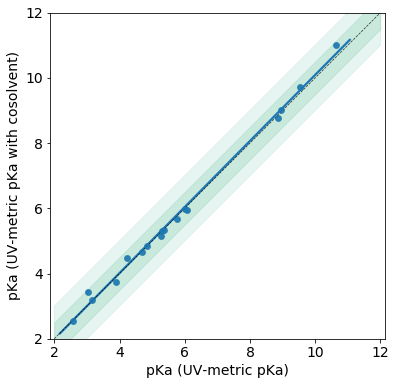

In [15]:
data = df_stat_conc
data.columns = ["Molecule ID", "pKa ID", "pKa (UV-metric pKa)", "pKa SEM water", "pKa (UV-metric pKa with cosolvent)", "pKa SEM cosolvent"]

plt.close()
plt.rcParams.update({'font.size': 14})
plot_correlation_with_SEM(x_lab="pKa (UV-metric pKa)", y_lab="pKa (UV-metric pKa with cosolvent)",data = data, x_err="pKa SEM water", y_err="pKa SEM cosolvent")
plt.savefig("water_vs_cosolvent_pKa_values_correlation_plot.pdf", dpi=300)
plt.show()

## Calculate statistical difference between UV-metric pKa and UV-metric pKa with cosolvent

In [16]:
df_stat_conc

,Molecule ID,pKa ID,pKa (UV-metric pKa),pKa SEM water,pKa (UV-metric pKa with cosolvent),pKa SEM cosolvent
0,SM01,SM01_pKa1,9.53,0.01,9.71,NaN
1,SM04,SM04_pKa1,6.02,0.01,5.97,NaN
2,SM06,SM06_pKa1,3.03,0.04,3.44,0.02
3,SM07,SM07_pKa1,6.08,0.01,5.96,NaN
4,SM08,SM08_pKa1,4.22,0.01,4.47,NaN
5,SM11,SM11_pKa1,3.89,0.01,3.74,NaN
6,SM12,SM12_pKa1,5.28,0.01,5.16,NaN
7,SM13,SM13_pKa1,5.77,0.01,5.68,NaN
8,SM14,SM14_pKa1,2.58,0.01,2.56,NaN
9,SM14,SM14_pKa2,5.30,0.01,5.29,NaN


In [17]:
data = np.asarray(df_stat_conc[["pKa (UV-metric pKa)", "pKa (UV-metric pKa with cosolvent)"]])
print("slope:", format(slope(data), '.2f'))
print("mean difference:", format(me(data), '.2f'))
print("mean absolute difference:",format(mae(data), '.2f'))
print("R-squared:",format(r2(data), '.2f'))
print("RMSD:",format(rmse(data), '.2f'))


slope: 1.01
mean difference: -0.04
mean absolute difference: 0.12
R-squared: 1.00
RMSD: 0.17


## Calculate bootstrapped confidence intervals for statistics

In [21]:
# Configuration: statistics to compute.
stats_funcs = collections.OrderedDict([
    ('RMSD', rmse),
    ('MAD', mae),
    ('MD', me),
    ('R2', r2),
    ('m', slope),
    ])

# Create lists of stats functions to pass to compute_bootstrap_statistics.
stats_funcs_names, stats_funcs = zip(*stats_funcs.items())

data = np.asarray(df_stat_conc[["pKa (UV-metric pKa)", "pKa (UV-metric pKa with cosolvent)"]])
bootstrap_statistics = compute_bootstrap_statistics(data, stats_funcs, n_bootstrap_samples=10000)

In [36]:
for i in range(5):
    print(stats_funcs_names[i])
    print(bootstrap_statistics[i]) #[statistics[stats_func_idx], confidence_interval, samples_statistics])

RMSD
[0.16620327737973378, (0.09009798587550963, 0.22997442313030744), array([0.04345383, 0.04844645, 0.04880935, ..., 0.27837765, 0.28578066,
       0.28912647])]
MAD
[0.11882352941176479, (0.06823529411764725, 0.17823529411764713), array([0.03705882, 0.03941176, 0.04      , ..., 0.23470588, 0.23647059,
       0.24529412])]
MD
[-0.03764705882352944, (-0.12000000000000005, 0.03470588235294122), array([-0.20588235, -0.20352941, -0.20294118, ...,  0.08235294,
        0.08235294,  0.08764706])]
R2
[0.9953999236579043, (0.9895205825092644, 0.9988580135657531), array([0.9631115 , 0.96655206, 0.96972183, ..., 0.99966295, 0.99966879,
       0.99974582])]
m
[1.0128802273300677, (0.9534295760737729, 1.0489558494635205), array([0.81712432, 0.84256818, 0.85318563, ..., 1.07061106, 1.07324186,
       1.07498368])]


RMSD 0.17 95% CI [0.09, 0.23]
MAD 0.12 95% CI [0.07, 0.18]
MD -0.04 95% CI [-0.12, 0.03]
R2 1.00 95% CI [0.99, 1.00]
m 1.01 95% CI [0.95, 1.05]